In [1]:
# Install required libraries
!pip install pandas nltk scikit-learn transformers torch textblob -q

# Import libraries
import os
import pandas as pd
import re
import nltk
import glob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
from transformers import pipeline
from google.colab import files

# Download necessary NLTK data to prevent errors
# This specifically fixes the "Resource punkt_tab not found" error
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True) # Added to fix the LookupError

print("✅ All libraries are installed and imported successfully.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.1 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

2025-11-26 08:14:47.956588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764144888.117443      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764144888.162451      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

✅ All libraries are installed and imported successfully.


In [2]:
# --- Week 1: Data Collection & Input ---
import os
import glob

# 1. Define the path to your Kaggle input data
# In Kaggle, data is typically in '../input/dataset-name/'
# We'll search all subdirectories of ../input/ for .txt files
kaggle_input_dir = '../input/'
print(f"Searching for .txt files in {kaggle_input_dir}...")

# 2. Find all .txt files in the input directory and its subdirectories
# The recursive=True flag searches all subfolders
file_paths = glob.glob(os.path.join(kaggle_input_dir, '**', '*.txt'), recursive=True)

if not file_paths:
    print("  - ⚠️ No .txt files found in the '../input/' directory.")
    print("  - Please use the '+ Add data' button in Kaggle to add your .txt file(s) as a dataset.")
else:
    for f_path in file_paths:
        print(f"  - Found file: '{f_path}'")

# 3. Define the function to read plain text files (this is unchanged)
def read_text_file(filepath):
    """Reads content from a plain .txt file."""
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            content = f.read()
        return content
    except Exception as e:
        print(f"Error reading file {filepath}: {e}")
        return None

print(f"\n✅ Week 1 complete. {len(file_paths)} file(s) are ready to be processed.")

Searching for .txt files in ../input/...
  - Found file: '../input/dataset15/dataset4.txt'
  - Found file: '../input/dataset15/dataset2.txt'
  - Found file: '../input/dataset15/datset1.txt'
  - Found file: '../input/dataset15/dataset3.txt'

✅ Week 1 complete. 4 file(s) are ready to be processed.


In [3]:
# --- Week 2: Data Preprocessing ---

def preprocess_text(text):
    """Cleans, normalizes, and tokenizes text for modeling."""
    text = re.sub(r'[^a-zA-Z\\s]', '', text, re.I|re.A)
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return " ".join(lemmatized_tokens)

print("✅ Week 2 functions defined (preprocess_text).")

✅ Week 2 functions defined (preprocess_text).


In [4]:
# --- Week 3: Topic Modeling (LDA Only) ---

def get_topics_lda(text, n_topics=5, n_words=7):
    """Extracts topics using LDA and returns them as a string AND a list."""
    report_string = "--- 🔬 Key Themes (LDA) ---\n"
    documents = [text]
    vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, stop_words='english')
    tfidf = vectorizer.fit_transform(documents)

    if tfidf.shape[1] < n_topics:
        return report_string + "Warning: Text is too short for meaningful topic modeling.\n", []

    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(tfidf)
    feature_names = vectorizer.get_feature_names_out()

    topics_list = []  # To store topics for the recommendation engine
    for topic_idx, topic_words in enumerate(lda.components_):
        top_words = [feature_names[i] for i in topic_words.argsort()[:-n_words - 1:-1]]
        report_string += f"Topic {topic_idx + 1}: {', '.join(top_words)}\n"
        topics_list.append(top_words) # Add the topic words to our list

    return report_string, topics_list # Return both the report and the list

print("✅ Week 3 functions defined (LDA only).")



✅ Week 3 functions defined (LDA only).


In [5]:
# --- Week 4: Sentiment Analysis ---

def get_sentiment(text):
    """Performs sentiment analysis and returns the score and a report string."""
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity

    if polarity > 0.1: sentiment = 'Positive 😊'
    elif polarity < -0.1: sentiment = 'Negative 😠'
    else: sentiment = 'Neutral 😐'

    report_string = f"--- 📊 Sentiment Analysis ---\n"
    report_string += f"Overall Sentiment: {sentiment}\n"
    report_string += f"Polarity Score: {polarity:.2f} (Range: -1.0 to +1.0)\n"

    return polarity, report_string

print("✅ Week 4 functions defined (get_sentiment).")

✅ Week 4 functions defined (get_sentiment).


In [6]:
# --- Week 5: Summarization & Insights Generation ---

def generate_summary(text):
    """Generates an abstractive summary and returns it as a string."""
    report_string = "--- ✨ Abstractive Summary ---\n"
    try:
        # Use device=-1 to force CPU, which is more stable on some Colab instances
        summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6", device=-1)
        # Truncate text to avoid model length limits
        summary = summarizer(text[:1024], max_length=150, min_length=30, do_sample=False)
        report_string += summary[0]['summary_text'] + "\n"
    except Exception as e:
        report_string += f"Could not generate summary: {e}\n"
    return report_string

def generate_recommendations(polarity, topics):
    """Generates simple actionable insights based on analysis results."""
    report_string = "--- 💡 Actionable Insights & Recommendations ---\n"

    if not topics: # Check if topics list is empty
        report_string += "Recommendation: No specific topics were identified for recommendations.\n"
        return report_string

    # Get the first 3 words of the most important topic
    top_topic_words = topics[0][:3]

    if polarity < -0.1:
        report_string += f"Recommendation: The overall sentiment is negative. It is advised to investigate feedback related to the key topics identified, such as '{', '.join(top_topic_words)}'.\\n"
    elif polarity > 0.1:
        report_string += f"Recommendation: The positive sentiment is strong. Consider leveraging this momentum by promoting aspects related to topics like '{', '.join(top_topic_words)}'.\\n"
    else:
        report_string += "Recommendation: The sentiment is neutral. Further analysis may be needed to understand specific opinions.\n"
    return report_string

print("✅ Week 5 functions defined (summarization and recommendations).")

✅ Week 5 functions defined (summarization and recommendations).


In [7]:
# --- Weeks 6-7: Visualization & Reporting ---

# Import the libraries needed for plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from wordcloud import WordCloud

def generate_visualizations(text, polarity_score):
    """Generates and displays visualizations (graphs)."""
    print("\n" + "--- 🖼️ Visualizations ---")

    # 1. Word Cloud (from your PDF)
    try:
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
    except ValueError:
        print("Could not generate word cloud (text might be too short).")

    # 2. Sentiment Distribution Chart (from your PDF)
    color = 'green' if polarity_score > 0.1 else ('red' if polarity_score < -0.1 else 'grey')
    fig = go.Figure(go.Bar(x=[polarity_score], y=['Sentiment'], orientation='h', marker=dict(color=color)))
    fig.update_layout(title='Overall Sentiment Polarity Score', xaxis_title='Score (-1.0 to +1.0)', xaxis=dict(range=[-1, 1]))
    fig.show()

print("✅ Weeks 6-7 functions defined (generate_visualizations).")


✅ Weeks 6-7 functions defined (generate_visualizations).




🚀 PROCESSING FILE: dataset4.txt
--- Preview of Cleaned Text (first 300 chars) ---
Title: The Silent Garden

In the heart of a small, forgotten town stood a quiet garden surrounded by old stone walls. The moment anyone stepped inside, the world outside seemed to fade into a distant murmur. The air was cool, carrying the faint scent of jasmine and earth. Tall trees formed a natural...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

Device set to use cpu



--- 🔬 Key Themes (LDA) ---
Topic 1: worry, world, whisper, warm, waiting, transformed, titlethesilentgardenintheheartofasmallforgottentownstoodaquietgardensurroundedbyoldstonewallsthemomentanyonesteppedinsidetheworldoutsideseemedtofadeintoadistantmurmurtheairwascoolcarryingthefaintscentofjasmineandearthtalltreesformedanaturalcanopyoverheadtheirbranchesswayinggentlyasifwhisperingsecretstothewindthecenterpieceofthegardenwasanancientfountaincarvedfrommarblewornsmoothbytimewatertrickledsoftlyfromitstierscreatingasoothingmelodythatechoedthroughthespacebirdsoftenperchedontheedgesdippingtheirbeaksintothecrystalclearpoolbeforeflutteringawaythesoundofthefountainfeltliketheheartbeatofthegardensteadypeacefulalivecolorfulflowersfilledeverycornerbloominginvibrantshadesofredpurpleandgoldbutterfliesdriftedbetweenthemmovingslowlyasiftheyhadallthetimeintheworldivyclimbedthestonewallsweavingpatternsthatresemblednaturesownartworkthegardenfeltuntouchedbychaosasanctuarycraftedbytimeitselfanarrowcobbleston

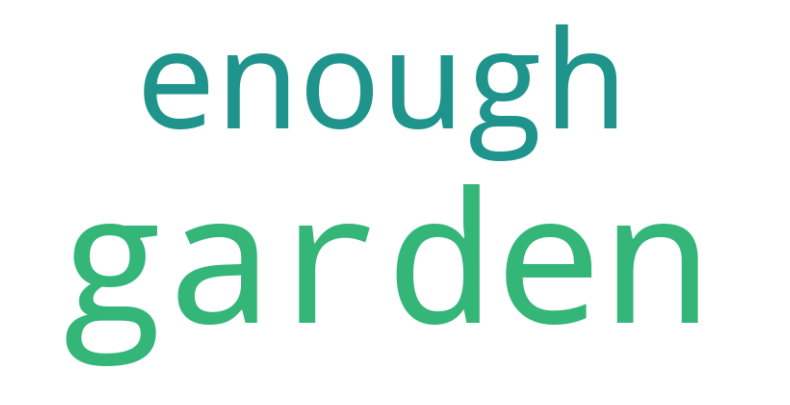



🚀 PROCESSING FILE: dataset2.txt
--- Preview of Cleaned Text (first 300 chars) ---
AI, Ethics, and Digital Forensics

Artificial intelligence (AI) has redefined the boundaries of digital forensics — it’s no longer about
simply analyzing evidence but about understanding patterns, behaviors, and system fingerprints.
However, data collected from the web often contains unwanted charac...


Device set to use cpu



--- 🔬 Key Themes (LDA) ---
Topic 1: data, model, like, topic, forensic, feature, scanner
Topic 2: copies, domain, texture, hybrid, removing, classification, quick
Topic 3: copies, domain, texture, hybrid, removing, classification, quick
Topic 4: copies, domain, texture, hybrid, removing, classification, quick
Topic 5: copies, domain, texture, hybrid, removing, classification, quick

--- 📊 Sentiment Analysis ---
Overall Sentiment: Neutral 😐
Polarity Score: 0.05 (Range: -1.0 to +1.0)

--- ✨ Abstractive Summary ---
 The TraceFinder project, developed at Infosys Labs, introduces an innovative method of scanner identification . Each scanner produces a unique noise pattern, similar to a fingerprint .

--- 💡 Actionable Insights & Recommendations ---
Recommendation: The sentiment is neutral. Further analysis may be needed to understand specific opinions.


--- 🖼️ Visualizations ---


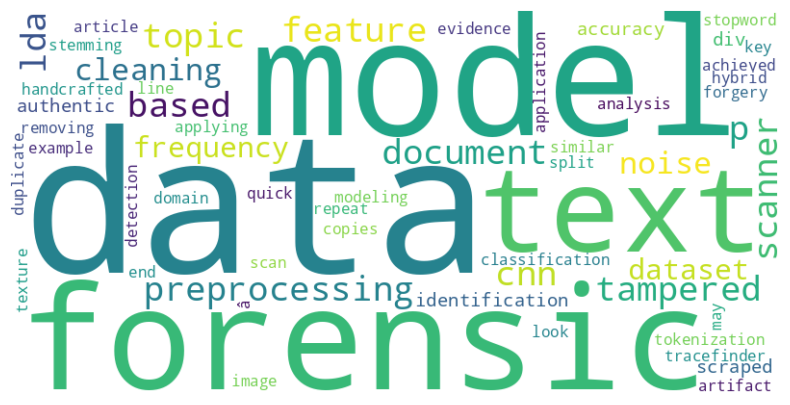



🚀 PROCESSING FILE: datset1.txt
--- Preview of Cleaned Text (first 300 chars) ---
Just got the new Apple Vision Pro, and it's 🤯! The spatial computing is mind-blowing.
But I've been reading a lot about data privacy issues.
The article at https://www.theverge.com talks about it.

Customer reviews on their site are mixed. One user wrote, "The AR features were a game-changer!!!"
but...


Device set to use cpu



--- 🔬 Key Themes (LDA) ---
Topic 1: word, tech, right, reserved, normalize, need, like
Topic 2: word, tech, right, reserved, normalize, need, like
Topic 3: word, tech, right, reserved, normalize, need, like
Topic 4: word, tech, right, reserved, normalize, need, like
Topic 5: disappointment, tech, word, right, reserved, need, normalize

--- 📊 Sentiment Analysis ---
Overall Sentiment: Neutral 😐
Polarity Score: -0.06 (Range: -1.0 to +1.0)

--- ✨ Abstractive Summary ---
 Customer reviews on the site are mixed . One user wrote, "The AR features were a game-changer!!!" But another said, "I have so many bugs... it's a huge waste of $$$"

--- 💡 Actionable Insights & Recommendations ---
Recommendation: The sentiment is neutral. Further analysis may be needed to understand specific opinions.


--- 🖼️ Visualizations ---


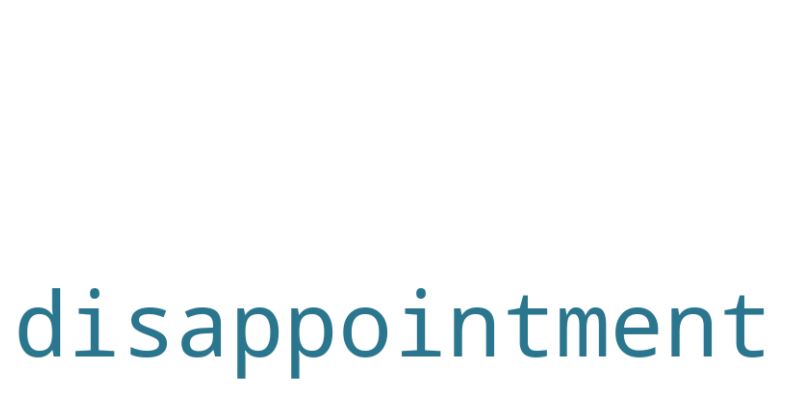



🚀 PROCESSING FILE: dataset3.txt
--- Preview of Cleaned Text (first 300 chars) ---
Title: Echoes Along the Riverbank

The river flowed quietly under the pale afternoon sun, carrying with it the stories of everything it had touched. On its surface, shimmering patterns danced like fragments of forgotten memories, swirling gently as the wind guided them along. Birds perched on the br...


Device set to use cpu



--- 🔬 Key Themes (LDA) ---
Topic 1: river, bridge, life, riverbank, casting, path, world
Topic 2: carrying, calmly, calm, brought, brilliance, breathtaking, blossom
Topic 3: carrying, calmly, calm, brought, brilliance, breathtaking, blossom
Topic 4: carrying, calmly, calm, brought, brilliance, breathtaking, blossom
Topic 5: carrying, calmly, calm, brought, brilliance, breathtaking, blossom

--- 📊 Sentiment Analysis ---
Overall Sentiment: Positive 😊
Polarity Score: 0.17 (Range: -1.0 to +1.0)

--- ✨ Abstractive Summary ---
 The river flowed quietly under the pale afternoon sun, carrying with it the stories of everything it had touched . Travelers often stopped there to rest, watching the water drift by as they gathered their thoughts . Birds perched on the branches of tall, graceful willows sang soft melodies that echoed over the water .

--- 💡 Actionable Insights & Recommendations ---
Recommendation: The positive sentiment is strong. Consider leveraging this momentum by promoting aspec

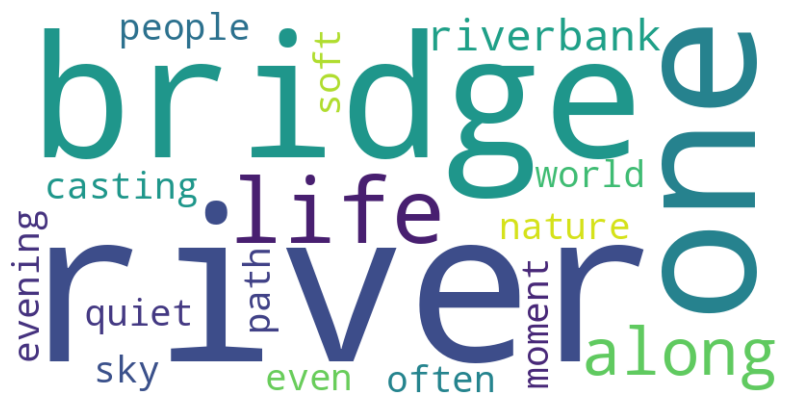



✅ All files processed up to Week 7.


In [8]:
# --- Pipeline Execution (Weeks 1-7) ---

for path in file_paths:
    print(f"\n\n{'='*40}\n🚀 PROCESSING FILE: {os.path.basename(path)}\n{'='*40}")

    if not os.path.exists(path):
        print(f"❌ Error: File not found at {path}. Skipping.")
        continue

    # --- Week 1: Read Data ---
    clean_text = read_text_file(path)
    if not clean_text:
        print(f"File {path} is empty or could not be read. Skipping.")
        continue

    print("--- Preview of Cleaned Text (first 300 chars) ---")
    print(clean_text[:300] + "...")

    # --- Week 2: Preprocess Data ---
    processed_text_for_model = preprocess_text(clean_text)

    # --- Week 3: Topic Modeling (LDA Only) ---
    lda_report, topics_list = get_topics_lda(processed_text_for_model)

    # --- Week 4: Sentiment Analysis ---
    polarity, sentiment_report = get_sentiment(clean_text)

    # --- Week 5: Summarization & Insights ---
    summary_report = generate_summary(clean_text)
    recommendation_report = generate_recommendations(polarity, topics_list)

    # --- Print all text reports ---
    print("\n" + lda_report)
    print(sentiment_report)
    print(summary_report)
    print(recommendation_report)

    # --- Weeks 6-7: Generate Graphs ---
    generate_visualizations(processed_text_for_model, polarity)

print("\n\n✅ All files processed up to Week 7.")